In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('adult_with_headers.csv')  # Make sure it's in the working directory

# Basic data exploration
print(df.info())
print(df.describe(include='all'))

# Replace '?' with NaN for consistency
df = df.replace(' ?', np.nan)

# Check missing values
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Identify numerical features
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Standard Scaling
scaler_std = StandardScaler()
df_std = df.copy()
df_std[num_features] = scaler_std.fit_transform(df_std[num_features])

# Min-Max Scaling
scaler_minmax = MinMaxScaler()
df_minmax = df.copy()
df_minmax[num_features] = scaler_minmax.fit_transform(df_minmax[num_features])

# Discussion:
# - Use StandardScaler when data is Gaussian (e.g., linear regression).
# - Use MinMaxScaler when you need values between 0–1 (e.g., neura


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None
                 age workclass        fnlwgt education  education_num  \
count   32561.0

In [4]:
# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Encoding
df_encoded = df.copy()

for col in cat_cols:
    if df_encoded[col].nunique() <= 5:
        df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)
    else:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

# Discussion:
# - One-Hot: No ordinal relationship; expands features; good for tree models.
# - Label: Implicit ordinal assumption; faster; not ideal for non-ordinal data.


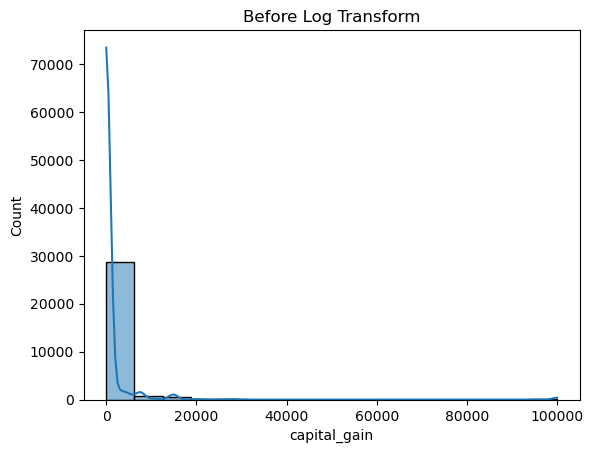

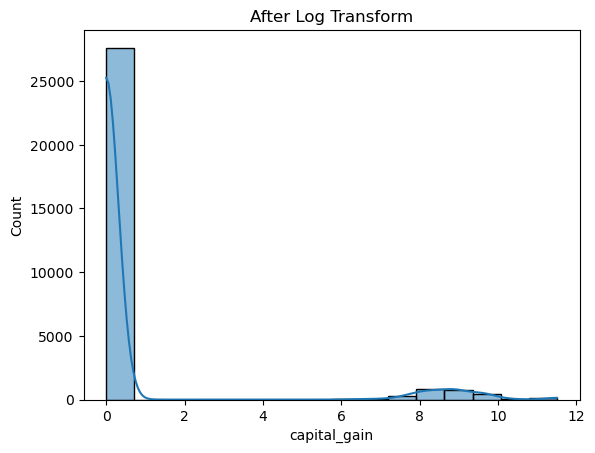

In [14]:
df_feat = df_encoded.copy()

# Feature 1: Age bucket
df_feat['age_group'] = pd.cut(df['age'], bins=[17, 30, 45, 60, 90], labels=['Young', 'Mid', 'Mature', 'Senior'])

# Feature 2: Work experience estimate
df_feat['exp_years'] = df['age'] - df['education_num']

# Log transformation for skewed feature (capital_gain)
df_feat['capital_gain'] = df_feat['capital_gain'].apply(lambda x: np.log1p(x))  # log1p handles zero

# Visualize skew
sns.histplot(df['capital_gain'], kde=True)
plt.title('Before Log Transform')
plt.show()

sns.histplot(df_feat['capital_gain'], kde=True)
plt.title('After Log Transform')
plt.show()


In [8]:
print(df.columns)


Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')


In [16]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.02, random_state=42)
pred = iso.fit_predict(df_feat.select_dtypes(include=[np.number]))

# Keep only inliers
df_clean = df_feat[pred == 1]

print(f"Removed {len(df_feat) - len(df_clean)} outliers")


Removed 604 outliers


Top relationships by PPS:
                 x              y   ppscore            case  is_valid_score  \
83   education_num      education  1.000000      regression            True   
64       education  education_num  1.000000      regression            True   
18             age      age_group  1.000000  classification            True   
398      exp_years      age_group  0.841391  classification            True   
19             age      exp_years  0.821000      regression            True   

                  metric  baseline_score  model_score  \
83   mean absolute error          2.5812     0.000000   
64   mean absolute error          1.8186     0.000000   
18           weighted F1          0.3240     1.000000   
398          weighted F1          0.3240     0.892780   
19   mean absolute error         10.4826     1.876385   

                        model  
83    DecisionTreeRegressor()  
64    DecisionTreeRegressor()  
18   DecisionTreeClassifier()  
398  DecisionTreeClassifier(

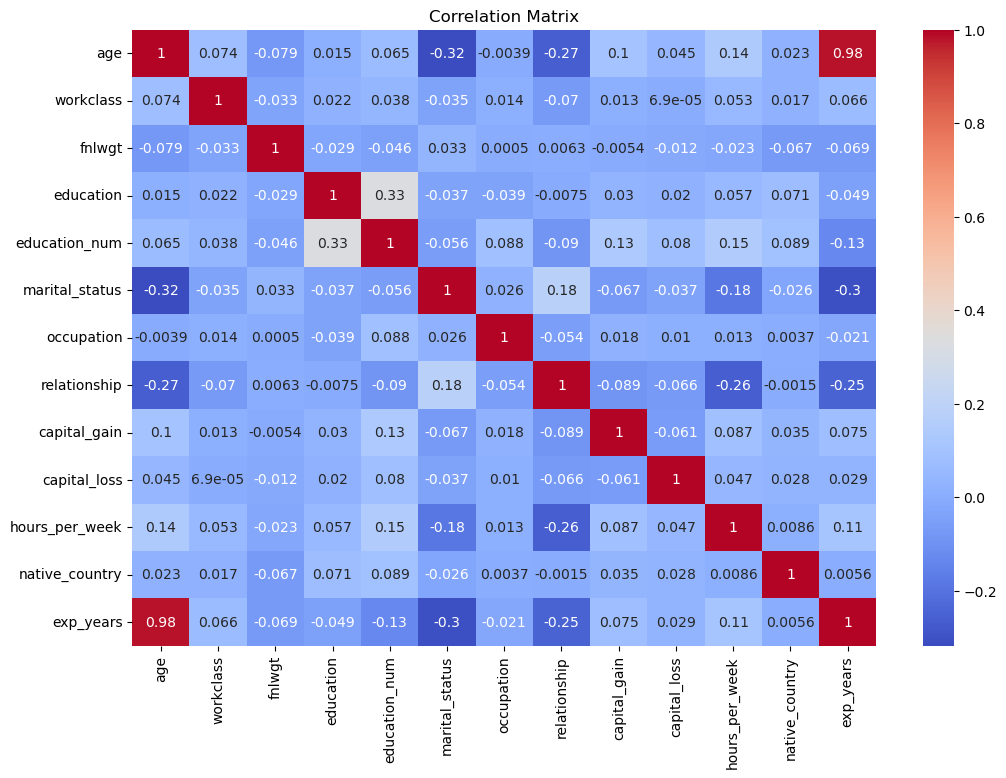

In [20]:
import ppscore as pps

# PPS Matrix
pps_matrix = pps.matrix(df_clean)
pps_matrix = pps_matrix[pps_matrix['x'] != pps_matrix['y']]
pps_matrix = pps_matrix.sort_values(by='ppscore', ascending=False)

print("Top relationships by PPS:")
print(pps_matrix.head())

# Select only numeric columns
numeric_df = df_clean.select_dtypes(include='number')

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

# Discussion:
# - Correlation only finds linear relationships.
# - PPS detects nonlinear and asymmetric relationships (e.g., one-way influence).
